# Redeconve manual

---

In [1]:
library(Redeconve)

Loading required package: foreach

Loading required package: ggrepel

Warning message:
"package 'ggrepel' was built under R version 4.2.3"
Loading required package: igraph

Warning message:
"package 'igraph' was built under R version 4.2.3"

Attaching package: 'igraph'


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union


Loading required package: scatterpie

Warning message:
"package 'scatterpie' was built under R version 4.2.3"


---

## 1 Main function

This part describes how to use the main function `deconvoluting` to perform single-cell deconvolution.

### Usage

The usage of `deconvoluting` is as follows:

In [2]:
## nums = deconvoluting(ref, st, cellnames=NULL, genemode, gene.list, var_thresh=0.025, exp_thresh=0.03, hpmode, hp, normalize = T, thre=1e-10, dopar=T, ncores, realtime=F, dir=NULL)

It does contains many parameters. Next, I will divide these parameters into several parts by function, and explain them one by one.

### 1.1 Necessary data for deconvolution

`ref` and `st` are the core data used for deconvolution. They are required as follows:

-   `ref`, the scRNA-seq data served as reference for deconvolution. It is a `Matrix` (or `dgCMatrix`) of unprocessed count-level scRNA-seq data. One row represents one gene and one column represents one cell.
-   `st`, the spatial transcriptomics to be deconvoluted. It is a `Matrix` (or `dgCMatrix`) of unprocessed spatial transcriptomics, represents raw counts in each spot. One row represents one gene and one column represents one spot.

### 1.2 Mode of gene selection

`genemode`, `gene.list`, `var_thresh` and `exp_thresh` are about how to deal with genes. `genemode` determines the mode of handling genes and `gene.list`, `var_thresh`, `exp_thresh` are associated with specific modes. Redeconve offers 3 alternative modes of dealing with genes:

1.  `default`: Use the intersection of genes in `ref` and `st`, without other treatment.
2.  `customized`: Indicating gene list yourself. Parameter `gene.list` is the list of genes you indicated. Note that only those genes within the intersection of `ref` and `st` would be used.
3.  `filtered`: We will use a built-in function `gene.filter` to screen some genes. This function will first take the intersection of `ref` and `st`, the use two indices, `var_thresh` and `exp_thresh` to filter genes. You can customize these two parameters as well.

-   `var_thresh` considers variance of reference. Genes whose variance across all cells in reference do not reach that threshold will be filtered out. The default value is 0.025.
-   `exp_thresh` considers expression in spatial transcriptomics. Genes whose average count across all spots in spatial transcriptomics is less that this value will be filtered out. The default value is 0.003.

### 1.3 Mode of determining hyperparameter

The hyperparamter is our key to single-cell resolution (See Methods for details). Here we still offers 3 modes to determine the hyperparameter:

1.  `default`: We will calculate a hyperparameter according to the number of genes and cells in reference (See Methods for details).
2.  `customized`: Indicating the hyperparameter yourself.
3.  `autoselection`: Redeconve will use a procedure to select the optimal hyperparameter. In this procedure, a series of hyperparameter will be set in the vicinity of the hyperparameter selected by mode `default`, and Redeconve will use these hyperparameters to perform deconvolution separately, then return the result with the best hyperparameter. You can see Methods for details about how we determine the best hyperparameter.

Note that in this procedure, several rounds of deconvolution will be performed, so it may take a long time. Under such circumstances, parallel computing will be beneficial.

### 1.4 Parallel computing

Sometimes the reference will contain tens of thousands of cells, or the spatial transcriptomics will contain tens of thousands of spots (e.g. when the data is from Slide-seq), then parallel computing is useful. Redeconve uses the package "doSNOW" to achieve parallel computing (which means there is a progress bar). Related parameters are `dopar` and `ncores`.

-   `dopar` determines whether to use parallel computing or not.
-   `ncores` indicates the number of cores to be used in parallel computing. It's recommended to manually set this parameter rather than use the function `detectCores` to avoid underlying errors.

<font color = red>! Important tips for parallel computing: !</font>

1.  Our underlying algorithm makes use of OpenBLAS, which may include parallel computing inside. Therefore, setting `system("export OPENBLAS_NUM_THREADS=1")` is necessary to avoid underlying errors.
2.  An error may be reported when the number of threads is too large : `Error in socketAccept(socket = socket, blocking = TRUE, open = "a+b",: all connections are in use`. If such error occurs, please reduce the number of cores.

### 1.5 Writing real-time results

Even with parallel computing, some dataset is still time-consuming. Redeconve is able to write results into disk in real time at the cost of some running speed. Related parameters are `realtime` and `dir`.

-   `realtime` determines whethers to write the results into disk in real time or not.
-   `dir` indicates the directory to write the results.

For real time results, the result of each spot will be write into a separate csv file, whose name is the barcode of the spot.

### 1.6 Other parameters

The left parameters are `cellnames`, `normalize` and `thre`.

-   `cellnames`: Chances are that you may not want to use all cells in reference to run deconvolution. Then you can indicate which cells will be used by this parameter. If you do not specify this parameter, all cells will be used.
-   `normalize`: Redeconve can also be used for bulk RNA-seq deconvolution. When doing this, normalization for reference is not required. When deconvoluting spatial transcriptomics, normalization is recommended.
-   `thre`: The estimated cell abundance will not be exactly 0. This parameter indicates that the abundance less than this value will be treated as 0. Generally this value does not need to be adjusted, and the result will remain the same within a relatively big range of this value.

### A demo

Next we will use a demo to give an example of how to use this function.

In [3]:
## load the data
data(basic)

promises::promise_resolve(sc)
promises::promise_resolve(st)

## check the dimensions of sc and st
dim(sc)
dim(st)

Loading required package: Matrix



<Promise [fulfilled: dgCMatrix]>

<Promise [fulfilled: dgCMatrix]>

[1] 19736   500

[1] 19736   428

In [4]:
## check the number cells in each cell type
table(annotations[,2])


                          Acinar cells                         Cancer clone A 
                                     3                                     33 
                        Cancer clone B            Ductal - APOL1 high/hypoxic 
                                    44                                     56 
Ductal - CRISP3 high/centroacinar like                  Ductal - MHC Class II 
                                   137                                     75 
         Ductal - terminal ductal like                        Endocrine cells 
                                    91                                      1 
                     Endothelial cells                            Fibroblasts 
                                     3                                      1 
                         Macrophages A                          Macrophages B 
                                     5                                      5 
                            Mast cells             

In [5]:
## deconvolution
# this may take a long time
res = deconvoluting(sc,st,genemode="def",hpmode="def",dopar=T,ncores=8)

[1] "Number of selected genes: 19736"
[1] "Calculating correlation matrix ..."
[1] "Set hyperparameter as: 7894"
[1] "Calculating Hessian matrix ..."
[1] "Running deconvolution ..."
  |======================================================================| 100%


-   `sc` and `st` are separately reference and spatial transcriptomics.
-   `genemode` is set to `"default"` to guarantee accuracy.
-   `hpmode` is set to `"default"` to improve efficiency.
-   `dopar` is set to `TRUE` (default value) and `ncores` is set to 8. You can raise the number of cores to improve efficiency.
-   For this dataset is not very large, `realtime` is set to `FALSE` (default value).
-   We want to use all cells in deconvolution, so we do not need to specify `cellnames`. Also, we do not need to adjust `thre`.

---

## 2 Dealing with large scRNA datasets

Nowadays the scale of scRNA datasets are getting increasingly larger. Sometimes the reference cells can reach to sub-million or million level. Although Redeconve possesses high efficiency, directly using so much cells as reference is both time consuming and low yield. Here we provide two ways to deal with such situation:

### 2.1 Cell-type deconvolution

Like other methods, Redeconve can also perform deconvolution at cell-type level. This part shows how to do so.

In [6]:
## get reference
ref = get.ref(sc,annotations,dopar = F)

## deconvolution
res.ct = deconvoluting(ref,st,genemode="def",hpmode="auto",dopar=T,ncores=8)

[1] "Number of selected genes: 19736"
[1] "Calculating correlation matrix ..."
[1] "iteration 1: hp = 49340"
[1] "Calculating Hessian matrix ..."
[1] "Running deconvolution ..."
  |======================================================================| 100%
[1] "iteration 2: hp = 493400"
[1] "Calculating Hessian matrix ..."
[1] "Running deconvolution ..."
  |======================================================================| 100%
[1] "iteration 3: hp = 4934000"
[1] "Calculating Hessian matrix ..."
[1] "Running deconvolution ..."
  |======================================================================| 100%
[1] "iteration 4: hp = 49340000"
[1] "Calculating Hessian matrix ..."
[1] "Running deconvolution ..."
  |======================================================================| 100%
[1] "iteration 5: hp = 493400000"
[1] "Calculating Hessian matrix ..."
[1] "Running deconvolution ..."
  |======================================================================| 100%
[1] "iteration 6

You can see that actually, only one more step is required to convert single-cell expression profile to that of cell type. The function `get.ref` will take the average expression of all cells in one cell type as the profile of that cell type. Note that `get.ref` also has parameters `dopar` and `ncores`, with which you can perform parallel computing when the scale of `sc` is too large.

For the main function, every thing is the same except that we set `hpmode` as `"autoselection"`, for there are only tens of cell types, then the speed is fast enough for us to run several rounds of deconvolution.

### 2.2 Sampling

Down-sampling is another way to deal with large scRNA datasets. Function `cell.sampling` is designed for this.

In [7]:
idx = cell.sampling(ncells = 500, annotations, size = 200, prot=T)
sc.ds = sc[,idx[,1]]

[1] "cells actually taken: 201"


This function returns a 2-columned matrix showing the barcodes and annotations of selected cells. The first parameter `ncells` is the original number of cells in scRNA dataset and the third `size` is the number of cells you want. The fourth parameter `prot` is to guarantee that at least one cell of each cell type in `annotations` is selected when set to `TRUE`.

In [8]:
res.ds = deconvoluting(sc.ds,st,genemode="def",hpmode="def",dopar=T,ncores=8)

[1] "Number of selected genes: 19736"
[1] "Calculating correlation matrix ..."
[1] "Set hyperparameter as: 48850"
[1] "Calculating Hessian matrix ..."
[1] "Running deconvolution ..."
  |======================================================================| 100%


---

## 3 Seurat interface

This package provided two functions to extract information from Seurat object to satisfy Redeconve's input:

In [9]:
library(Seurat)
library(SeuratData)

## installing data
InstallData("pbmc3k")
InstallData("stxBrain")

## sc
pbmc3k = UpdateSeuratObject(pbmc3k)
sclist = extract.seurat.sc(pbmc3k,anno_slot="seurat_annotations")

## st
stxBrain = LoadData('stxBrain', type = 'anterior1')
stlist = extract.seurat.st(stxBrain,coord_slot="anterior1")

## just for example
# res = deconvoluting(sclist[["expr"]],stlist[["expr"],genemode="filt",hpmode="auto",dopar=T,ncores=8)

Attaching SeuratObject

── Installed datasets ───────────────────────────────────── SeuratData v0.2.2 ──

✔ pbmc3k   3.1.4                        ✔ stxBrain 0.1.1


────────────────────────────────────── Key ─────────────────────────────────────

✔ Dataset loaded successfully
❯ Dataset built with a newer version of Seurat than installed
❓ Unknown version of Seurat installed


Warning message:
"The following packages are already installed and will not be reinstalled: pbmc3k"
Warning message:
"The following packages are already installed and will not be reinstalled: stxBrain"
Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version



---

## 4 Downstream analysis and visualization

Redeconve offers many built-in functions for downstream analysis and visualization.

### 4.1 Gaining interpretability

For we included a normalization procedure, the result of `deconvoluting` has only relative significance. Here are some functions related:

4.1.1  `to.proportion`: This function converts the result to proportion, i.e., the sum of cell abundance per spot is 1. This is convenient for visualization.

In [10]:
res.prop = to.proportion(res)

4.1.2  `to.absolute.abundance`: This function converts the result to absolute cell abundance with some priori knowledge. Parameter `aver.cell` is required to estimate the absolute abundance of each cell state. This value indicates the average number of cells in one spot. Users can determine it according to the platform of st data. For example, 10x Visium has a spot radius of about 50$\mu$m, so this value for a 10x Visium dataset is about 10.

In [11]:
res.ab = to.absolute.abundance(res,aver.cell=10)

4.1.3  `sc2type`: This function merges single-cell result to cell-type result according to annotations. Note that this function itself does not provide interpretability.

In [12]:
res.ctmerge = sc2type(res,annotations)

### 4.2 Cell occurrence

The function `cell.occur` shows the number of cells actually used in deconvolution, and the number of spots that every used cell occurs.

[1] "196 in 500 cells are used."


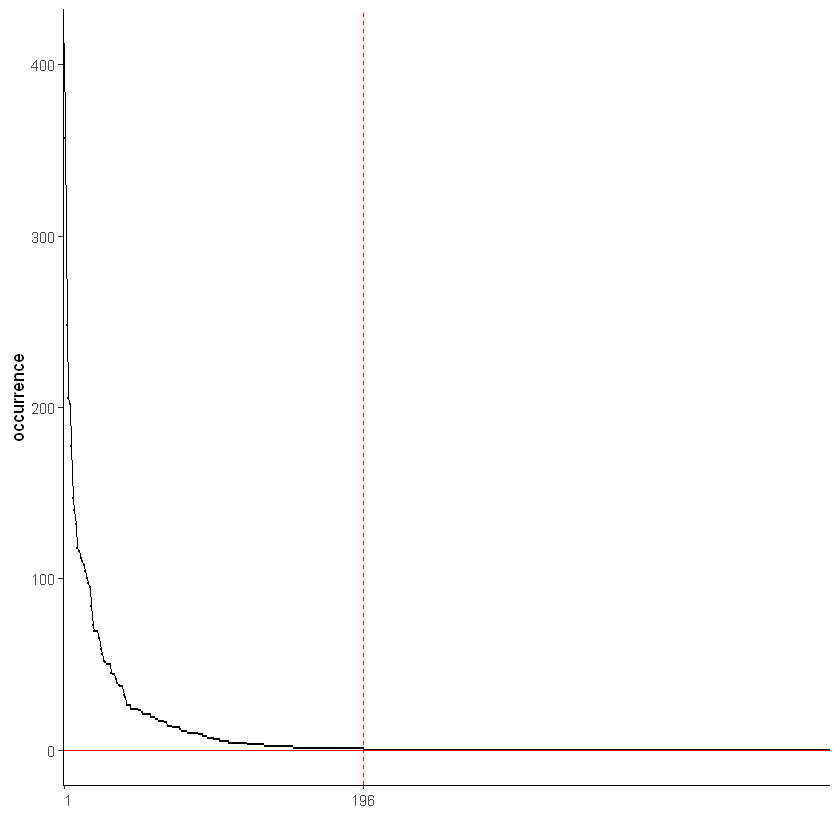

In [13]:
cell.occur(res)

### 4.3 Find cells of interest

Redeconve offers a function to plot mean vs sd, and highlighting those outliers. Users can then explore those cells. Note that this function can only be run after `cell.occur`, because it needs `occurred.cells` as input, which is an output of `cell.occur`.

 [1] "Cancer.clone.A.117"                        
 [2] "Acinar.cells.10"                           
 [3] "Ductal...CRISP3.high.centroacinar.like.62" 
 [4] "Macrophages.A"                             
 [5] "Fibroblasts.1"                             
 [6] "Ductal...CRISP3.high.centroacinar.like.311"
 [7] "Ductal...CRISP3.high.centroacinar.like.36" 
 [8] "Ductal...CRISP3.high.centroacinar.like.58" 
 [9] "Cancer.clone.A.115"                        
[10] "Ductal...CRISP3.high.centroacinar.like.271"


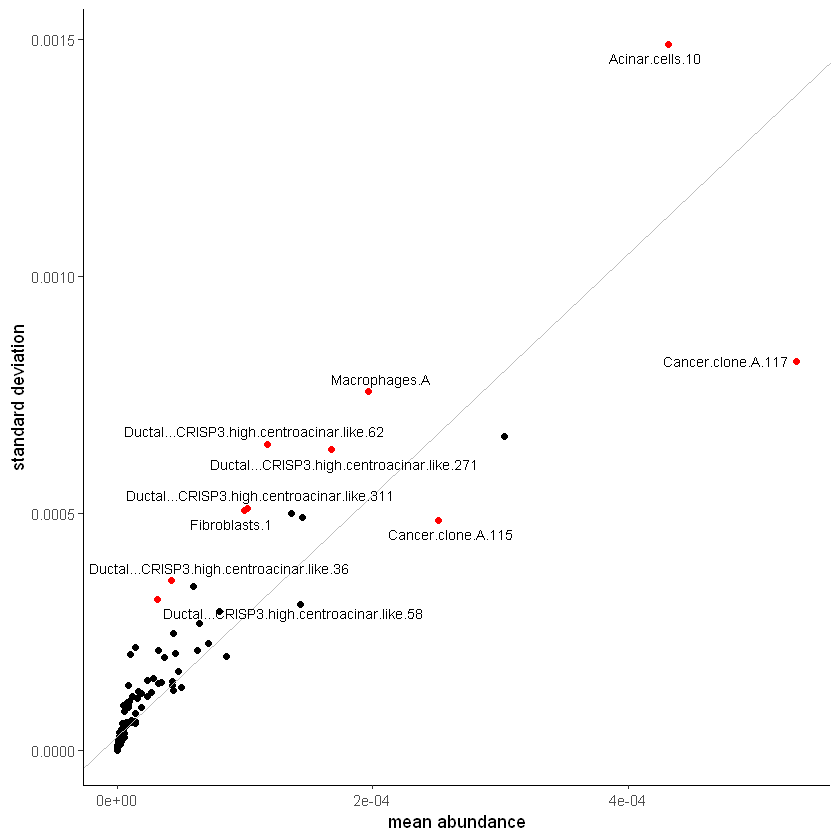

In [14]:
show.cellsofinterest(res, occurred.cells)

### 4.4 Spatial distributiom of all or some specific cells

The function `spatial.cell.number` can plot the abundance of all cells (or cell types) or some cells you indicate.

[[1]]


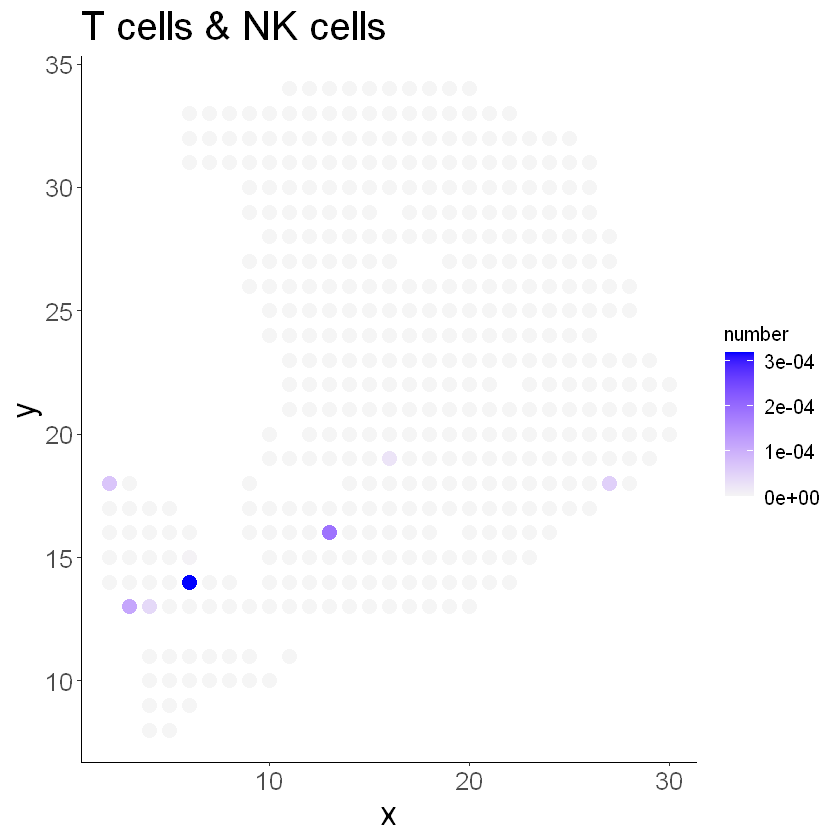

In [15]:
spatial.cell.number(res.ctmerge,cell.names="T cells & NK cells",coords=coords,size=4,pdfout=F)

Here we plotted the abundance of T cells & NK cells. When you want to plot the distribution of more than one cells, to set `pdfout` as `TRUE` is recommended.

### 4.5 Spatial pie chart

The function `spatial.pie` can plot the spatial pie chart, showing the proportion of each cell type in each spatial spot.

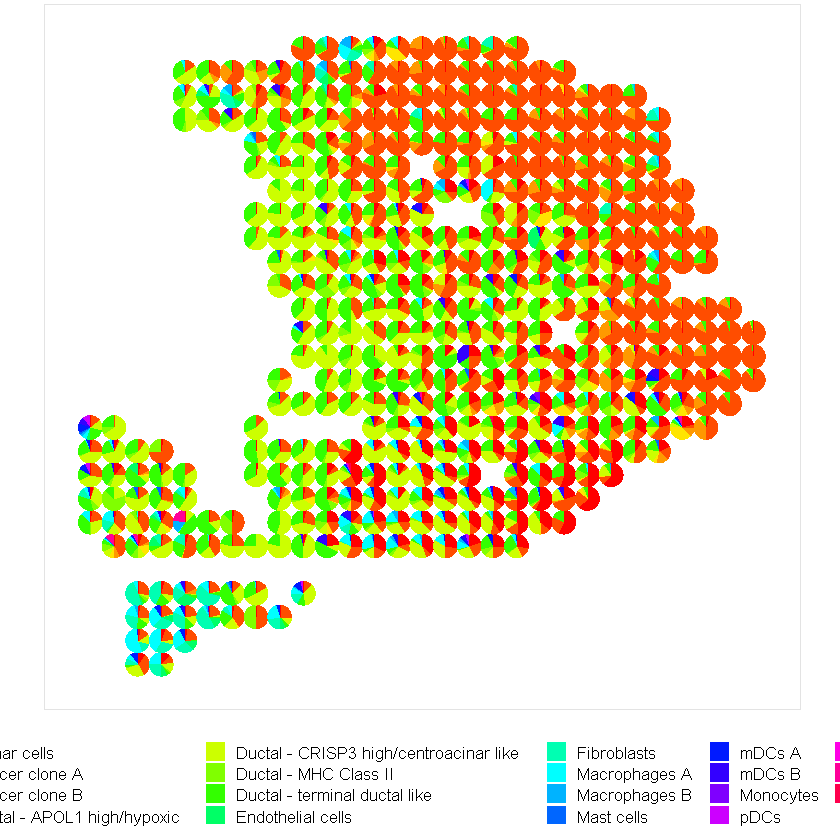

In [16]:
# For this is a demo, we use default colors. See function documentation for details.
spatial.piechart(res.ctmerge,coords)

### 4.6 Spot pie chart

The function `spot.pie` can plot the proportion of each cell type within a certain spot.

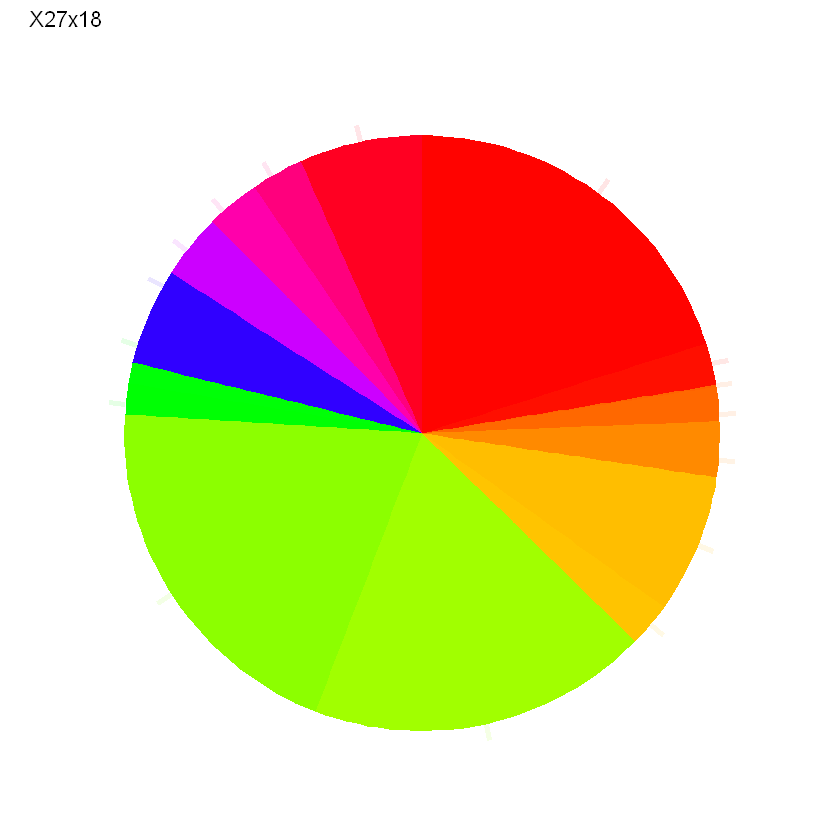

In [17]:
spot.pie(res[,"X27x18"],title="X27x18")

### 4.7 Co-localization

Function `coloc.network`infers a co-localization network from correlation of abundance of cells or cell types.

In [18]:
corr = cor(t(res.ctmerge),method = "pearson")
celltypes = levels(as.factor(annotations[,2]))
g = coloc.network(corr,thresh=0.4,cell.type=T,annotations=celltypes,ntypes=length(celltypes))

Warning message in cor(t(res.ctmerge), method = "pearson"):
"the standard deviation is zero"


The parameter `thresh` means that only correlation coefficient larger than this value is regarded as an edge.

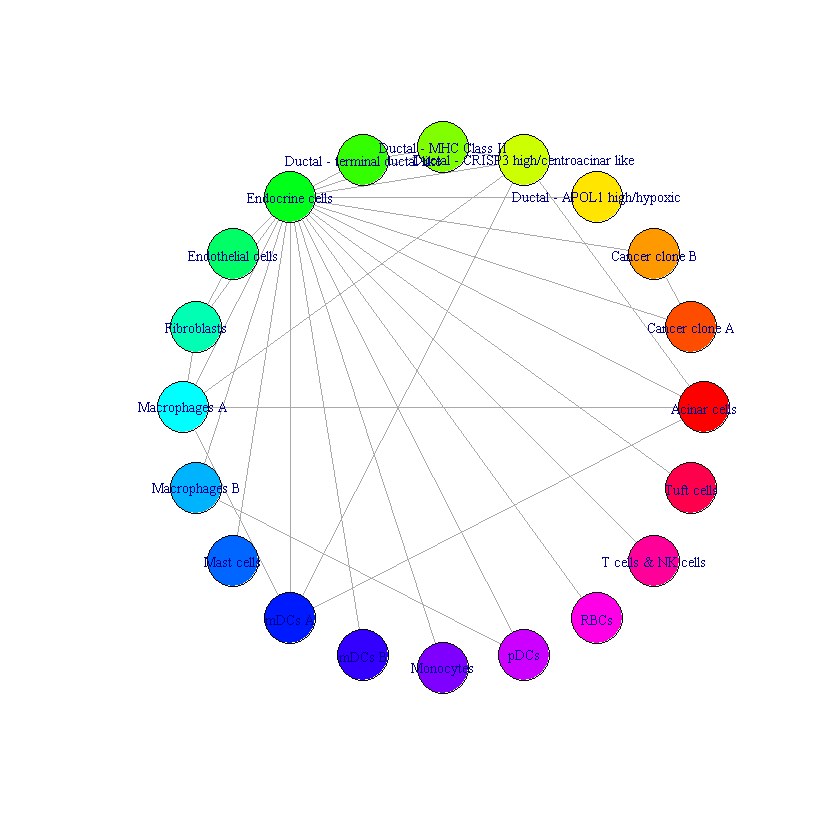

In [19]:
# plotting with igraph
plot(g, vertex.size = 20, vertex.label.cex = 0.7, layout=layout_in_circle)